# 78%以上を目指す

- 「名前にMrがついてるかどうか」という条件でSexを3分割にしてみる

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# 前処理

- Ageの補完は前回と同じ

In [3]:
middle = data["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
data["Middle"] = middle[0]
data.loc[(data["Middle"] != "Mr") 
         & (data["Middle"] != "Mrs") 
         & (data["Middle"] != "Miss") 
         & (data["Middle"] != "Master"), "Middle"] = "Other"
data.loc[(data["Middle"] == "Other") 
         & (data["Age"] < data.loc[data["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
data.loc[(data["Middle"] == "Other"), "Middle"] = "Other_post"
data.loc[data["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    data.loc[(data["Age"].isnull()) & (data["Middle"] == middle), "Age"] = data.loc[
        data["Middle"] == middle, "Age"].dropna().median()

- Sexを3分割(maleを2分割)

In [4]:
data.loc[(data["Middle"] == "Mr") & (data["Sex"] == "male"), "Sex"] = "Mr"
data.loc[(data["Middle"] != "Mr") & (data["Sex"] == "male"), "Sex"] = "notMr"

### テストデータに対しても同じ操作を行う(補完に関しては前回と同じ)

In [5]:
middle = test["Name"].str.split(", ", expand=True)
middle = middle[1].str.split(".", expand=True)
test["Middle"] = middle[0]
test.loc[(test["Middle"] != "Mr") 
         & (test["Middle"] != "Mrs") 
         & (test["Middle"] != "Miss") 
         & (test["Middle"] != "Master"), "Middle"] = "Other"
test.loc[(test["Middle"] == "Other") 
         & (test["Age"] < test.loc[test["Middle"] == "Other", "Age"].dropna().median()), "Middle"] = "Other_pre"
test.loc[(test["Middle"] == "Other"), "Middle"] = "Other_post"
test.loc[test["Age"].isnull(), ["Middle", "Age"]]
for middle in ["Mr", "Mrs", "Miss", "Master", "Other_pre", "Other_post"]:
    test.loc[(test["Age"].isnull()) & (test["Middle"] == middle), "Age"] = test.loc[
        test["Middle"] == middle, "Age"].dropna().median()
test["Fare"] = test["Fare"].fillna(test.loc[test["Middle"] == "Mr", "Fare"].dropna().median())
test.loc[(test["Middle"] == "Mr") & (test["Sex"] == "male"), "Sex"] = "Mr"
test.loc[(test["Middle"] != "Mr") & (test["Sex"] == "male"), "Sex"] = "notMr"

# X, yに分ける

In [6]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Middle
0,1,0,3,"Braund, Mr. Owen Harris",Mr,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",Mr,35.0,0,0,373450,8.0500,NaN,S,Mr


In [7]:
X = data.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin", "Embarked", "Middle"], axis=1)
y = data["Survived"]
X_test = test.drop(["PassengerId", "Name", "Ticket", "Cabin", "Embarked", "Middle"], axis=1)

In [8]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,Mr,22.0,1,0,7.2500
1,1,female,38.0,1,0,71.2833
2,3,female,26.0,0,0,7.9250
3,1,female,35.0,1,0,53.1000
4,3,Mr,35.0,0,0,8.0500


# ワンホットエンコーディング

- Pclass, Middle -> ワンホットエンコーディング

In [9]:
X = pd.get_dummies(X, columns=["Pclass"])
X = pd.get_dummies(X, columns=["Sex"])
X_test = pd.get_dummies(X_test, columns=["Pclass"])
X_test = pd.get_dummies(X_test, columns=["Sex"])

In [10]:
X.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_Mr,Sex_female,Sex_notMr
0,22.0,1,0,7.2500,0,0,1,1,0,0
1,38.0,1,0,71.2833,1,0,0,0,1,0
2,26.0,0,0,7.9250,0,0,1,0,1,0
3,35.0,1,0,53.1000,1,0,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,1,0,0


### 4-fold cross validation, Grid Search

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# RandomForest

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
def param():
  ret = {
      "n_estimators":[100, 200, 300],
      "max_features": [3, 5, 7, 10],
      "min_samples_split": [2, 10, 20],
  }
  return ret
gscv = GridSearchCV(RandomForestClassifier(random_state=0), param(), cv=4)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8417508417508418
Best parameters: {'max_features': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [14]:
rf = RandomForestClassifier(max_features=10, min_samples_split=10, n_estimators=200)
scores = cross_val_score(rf, X, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.82589286 0.86995516 0.83783784 0.82882883]
Average score: 0.840628670190049


# LogisticRegression

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
def param():
  ret = {
      'C':[0.001, 0.01, 0.1, 1, 10, 100],
  }
  return ret
gscv = GridSearchCV(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000), param(), cv=4)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8092031425364759
Best parameters: {'C': 0.1}


In [17]:
lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, C=0.1)
scores = cross_val_score(lr, X, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.80357143 0.8206278  0.79279279 0.81981982]
Average score: 0.8092029609686561


# SVM

In [18]:
from sklearn.svm import SVC

In [19]:
def param():
  ret = {
      'C':[0.001, 0.01, 0.1, 1, 10, 100],
      'gamma':[0.001, 0.01, 0.1, 1, 10, 100]
  }
  return ret
gscv = GridSearchCV(SVC(), param(), cv=4)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8002244668911336
Best parameters: {'C': 100, 'gamma': 0.001}


/Users/y_imagawa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [20]:
svm = SVC(C=100, gamma=0.001)
scores = cross_val_score(svm, X, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.78125    0.79820628 0.79279279 0.82882883]
Average score: 0.8002694749121319


# Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

In [22]:
def param():
  ret = {
      "max_depth": [2,4,6,8,10],
      "max_features": ['log2', 'sqrt','auto'],
      "min_samples_split": [3, 5, 7, 9],
      "min_samples_leaf": [1,5,8],
      "criterion": ["gini", "entropy"],
  }
  return ret
gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), param(), cv=4)
gscv.fit(X, y)

print('Best score: {}'.format(gscv.best_score_))
print('Best parameters: {}'.format(gscv.best_params_))

Best score: 0.8249158249158249
Best parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7}


In [23]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=6, max_features="log2", min_samples_split=7)
scores = cross_val_score(dt, X, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.74107143 0.82959641 0.83333333 0.78828829]
Average score: 0.798072365687276


# アンサンブル学習(Voting)

In [24]:
from sklearn.ensemble import VotingClassifier

In [25]:
vote_clf =  VotingClassifier([('lr', lr), ('svm', svm), ('dt', dt), ('rf', rf)], weights=(1, 1, 1, 1))
scores = cross_val_score(vote_clf, X, y, cv=4)
print("Cross-Validation scores: {}".format(scores))
print("Average score: {}".format(np.mean(scores)))

Cross-Validation scores: [0.82589286 0.83408072 0.7972973  0.81981982]
Average score: 0.8192726729371909


In [26]:
vote_clf.fit(X, y)
print()

# 提出用ファイルを作成

In [27]:
pred = vote_clf.predict(X_test)
submit = pd.DataFrame({"PassengerId":test["PassengerId"], "Survived":pred})
submit.to_csv("gender_submission.csv",index=False)

# 結果

- 80.86% !!!!!

### 重み探索について

- 今まではRandomForestの重みがやたらと大きかった。
- 重みを自分で考えて振り分けることで、最高スコアを出すことができた。
- 重み探索を行うことで、トレーニングデータに対してオーバーフィッティングが起こっているのではないかと思った。

# 重要度をみてみる

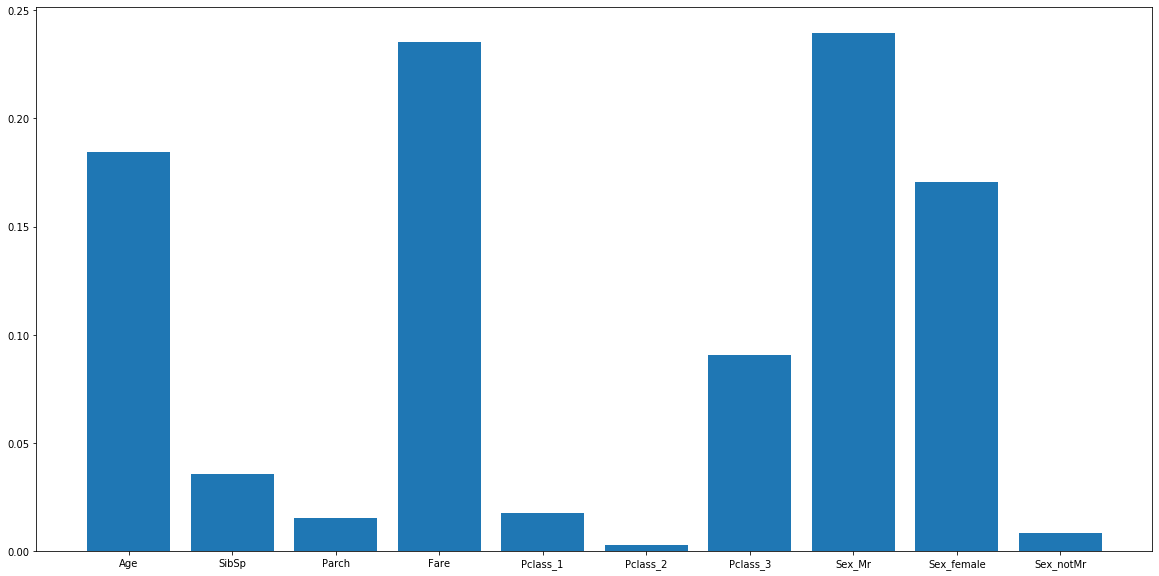

In [28]:
rf.fit(X, y)
feature = rf.feature_importances_
plt.figure(figsize=(20, 10))
plt.bar(range(len(feature)), feature, tick_label=X.columns)
plt.show()